In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy as sc
import scipy
import warnings
from tqdm.notebook import tqdm
import pickle as pkl
from matplotlib.patches import Polygon

import matplotlib as mpl
import seaborn as sns

In [2]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

## load in processed mouse liver data

In [9]:
#adata_m = sc.read_h5ad('../../../../new_h5s/all_batches_mouse_only_processed.h5ad')
adata_m = sc.read_h5ad('../../../../new_h5s/Processed_Liver_All_Batches_mouse_deconV2_2.h5ad')

In [10]:
adata_m.obs.CellType.value_counts()

mc38          2787
Hepatocyte    2300
Myeloid        921
Lymphocyte     166
Kupffer        161
MSC            144
LSEC           144
Name: CellType, dtype: int64

In [12]:
##get plate map file 
plate_map='~/projects/XYZeq/data/20181219_species_exp/plate23_map.csv'


spatial_map=pd.read_csv(plate_map, header=None, names=['barcode', 'X', 'Y'])

spatial_map['Y'] = -spatial_map['Y']

tmp=[]

for index, row in spatial_map.iterrows():
    if row['X']%2==0:
        m=row['Y'] - .5
        tmp.append(m)
    else:
        tmp.append(row['Y'])
        
spatial_map['Y_offset'] = pd.DataFrame(tmp)

spatial_map = spatial_map.drop(['Y'],axis=1)

spatial_map.columns = ['barcode','X','Y']


In [13]:
#remove overhang columns 43 and 43

spatial_map = spatial_map[spatial_map['X'] <= 42]

In [14]:
##add coordinates as obs

adata_m.obs = adata_m.obs.reset_index().merge(
    spatial_map, on='barcode',how='left').set_index('index')

In [15]:
adata_batch1 = adata_m[adata_m.obs.batch == 'L10C']
adata_batch2 = adata_m[adata_m.obs.batch == 'L20C']
adata_batch3 = adata_m[adata_m.obs.batch == 'L20T']
adata_batch4 = adata_m[adata_m.obs.batch == 'L30C']



/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


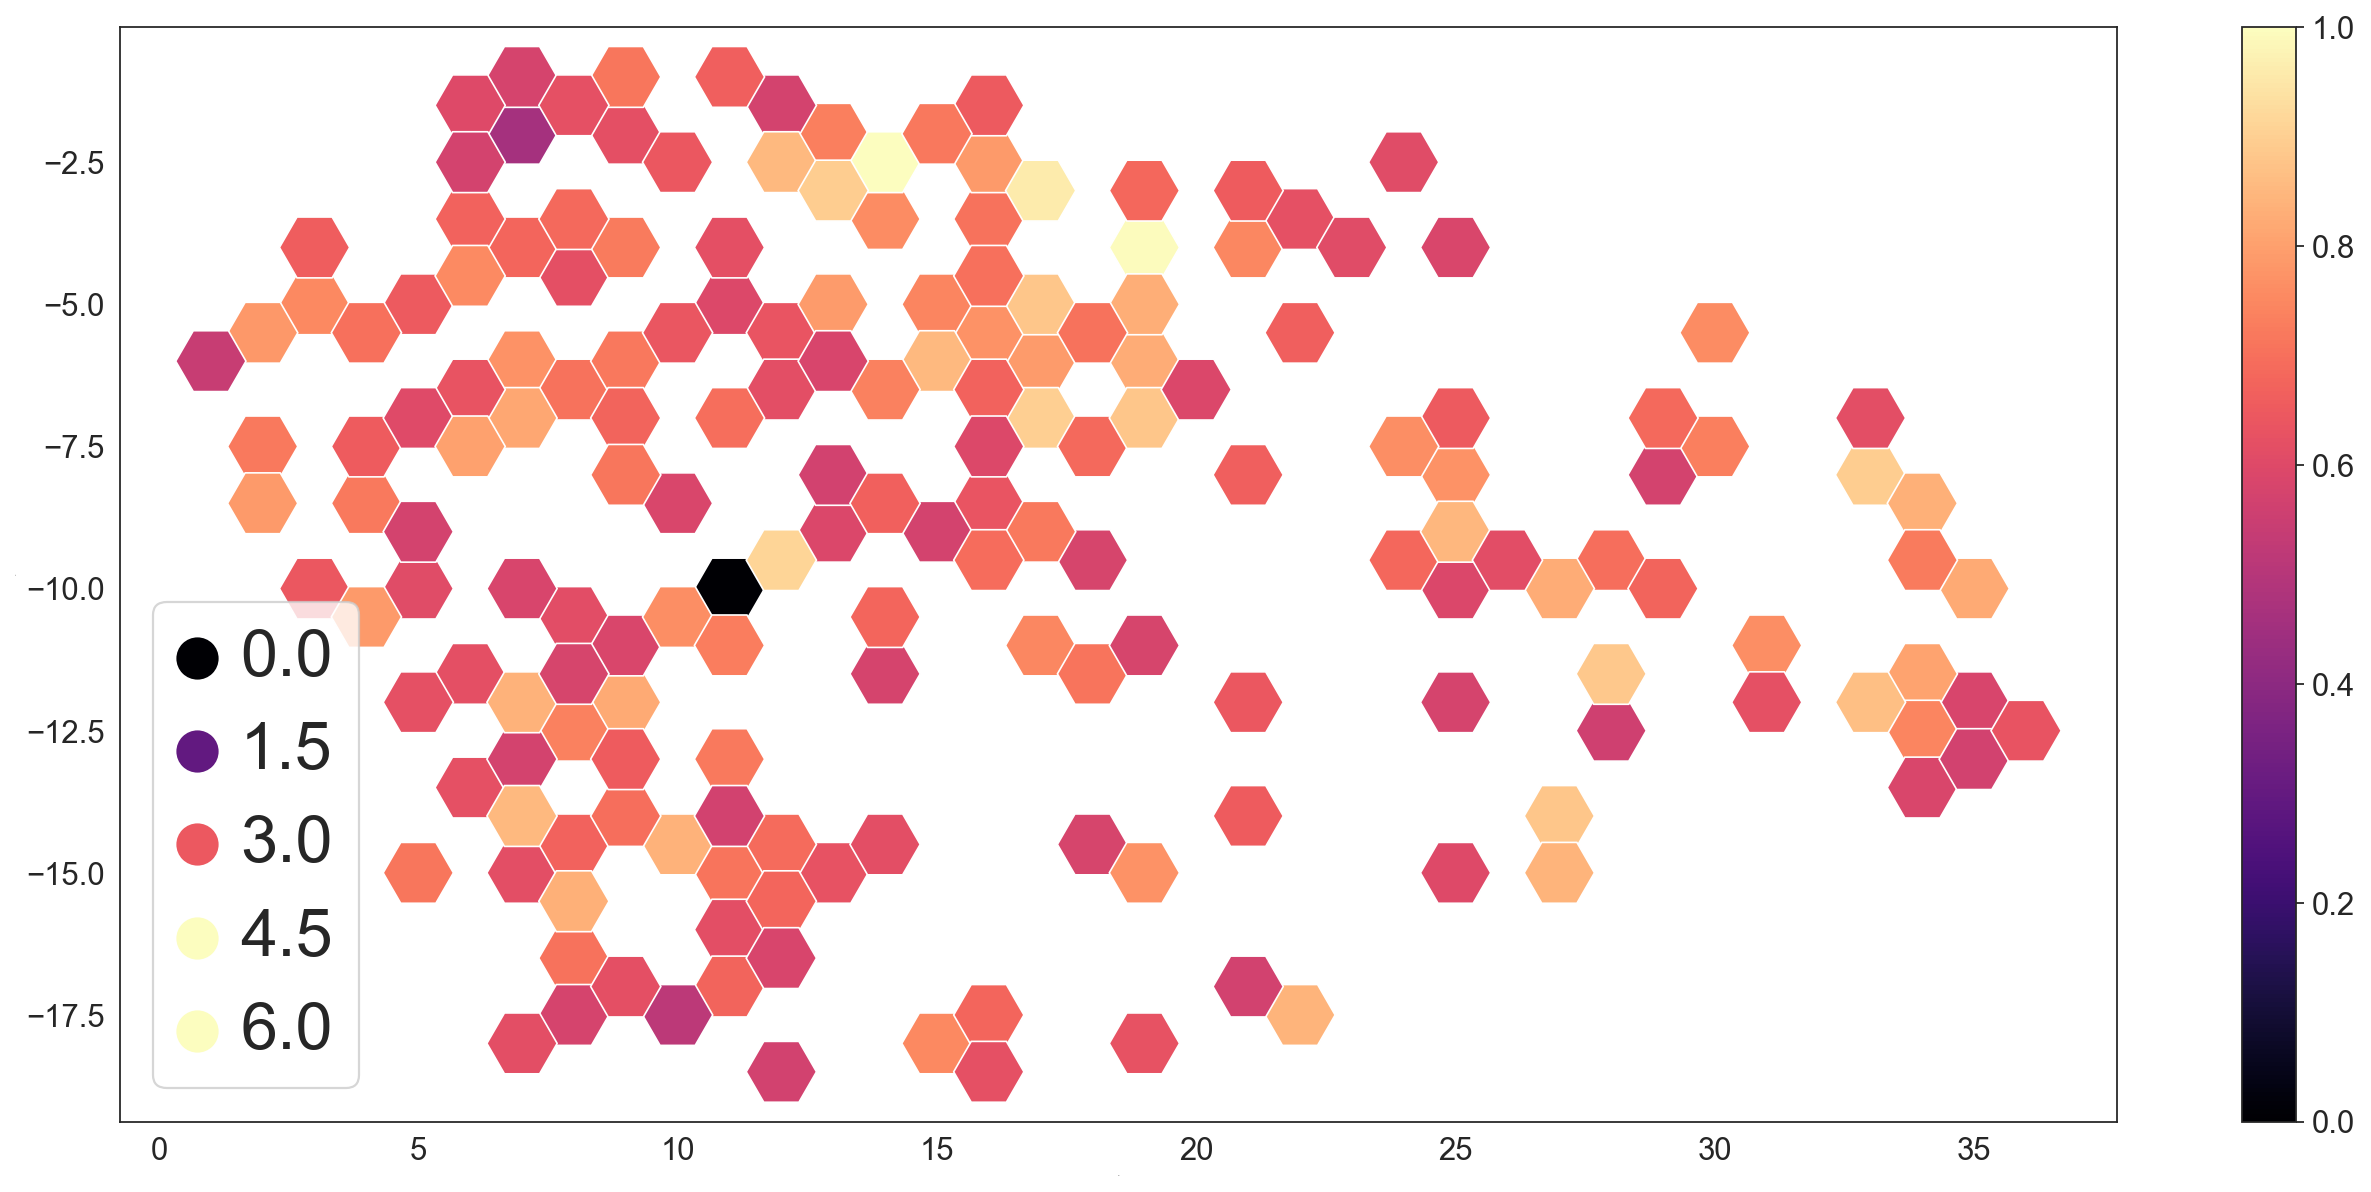

In [20]:
plt.rcParams['figure.figsize'] = [20, 9]

plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 0
plt.rcParams['axes.titlesize'] = 30



sns.set_style("white", {'axes.grid' : False})

g = sns.scatterplot(data=adata_batch1.obs.groupby(['barcode','X','Y']).sum().reset_index(),
                x='X',
                y='Y',
                marker="H",
                s=1000,
                hue=np.log10(adata_batch1.obs.groupby(['barcode','X','Y']).sum().n_counts.tolist()),
                palette='magma',
                legend='brief'
                        ###for solid colors:
                #c=[cell_type_color]#[adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()]

               )

points = g.get_children()[1]

points.cmap=mpl.cm.magma
plt.colorbar(mappable=points,)

In [46]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
 

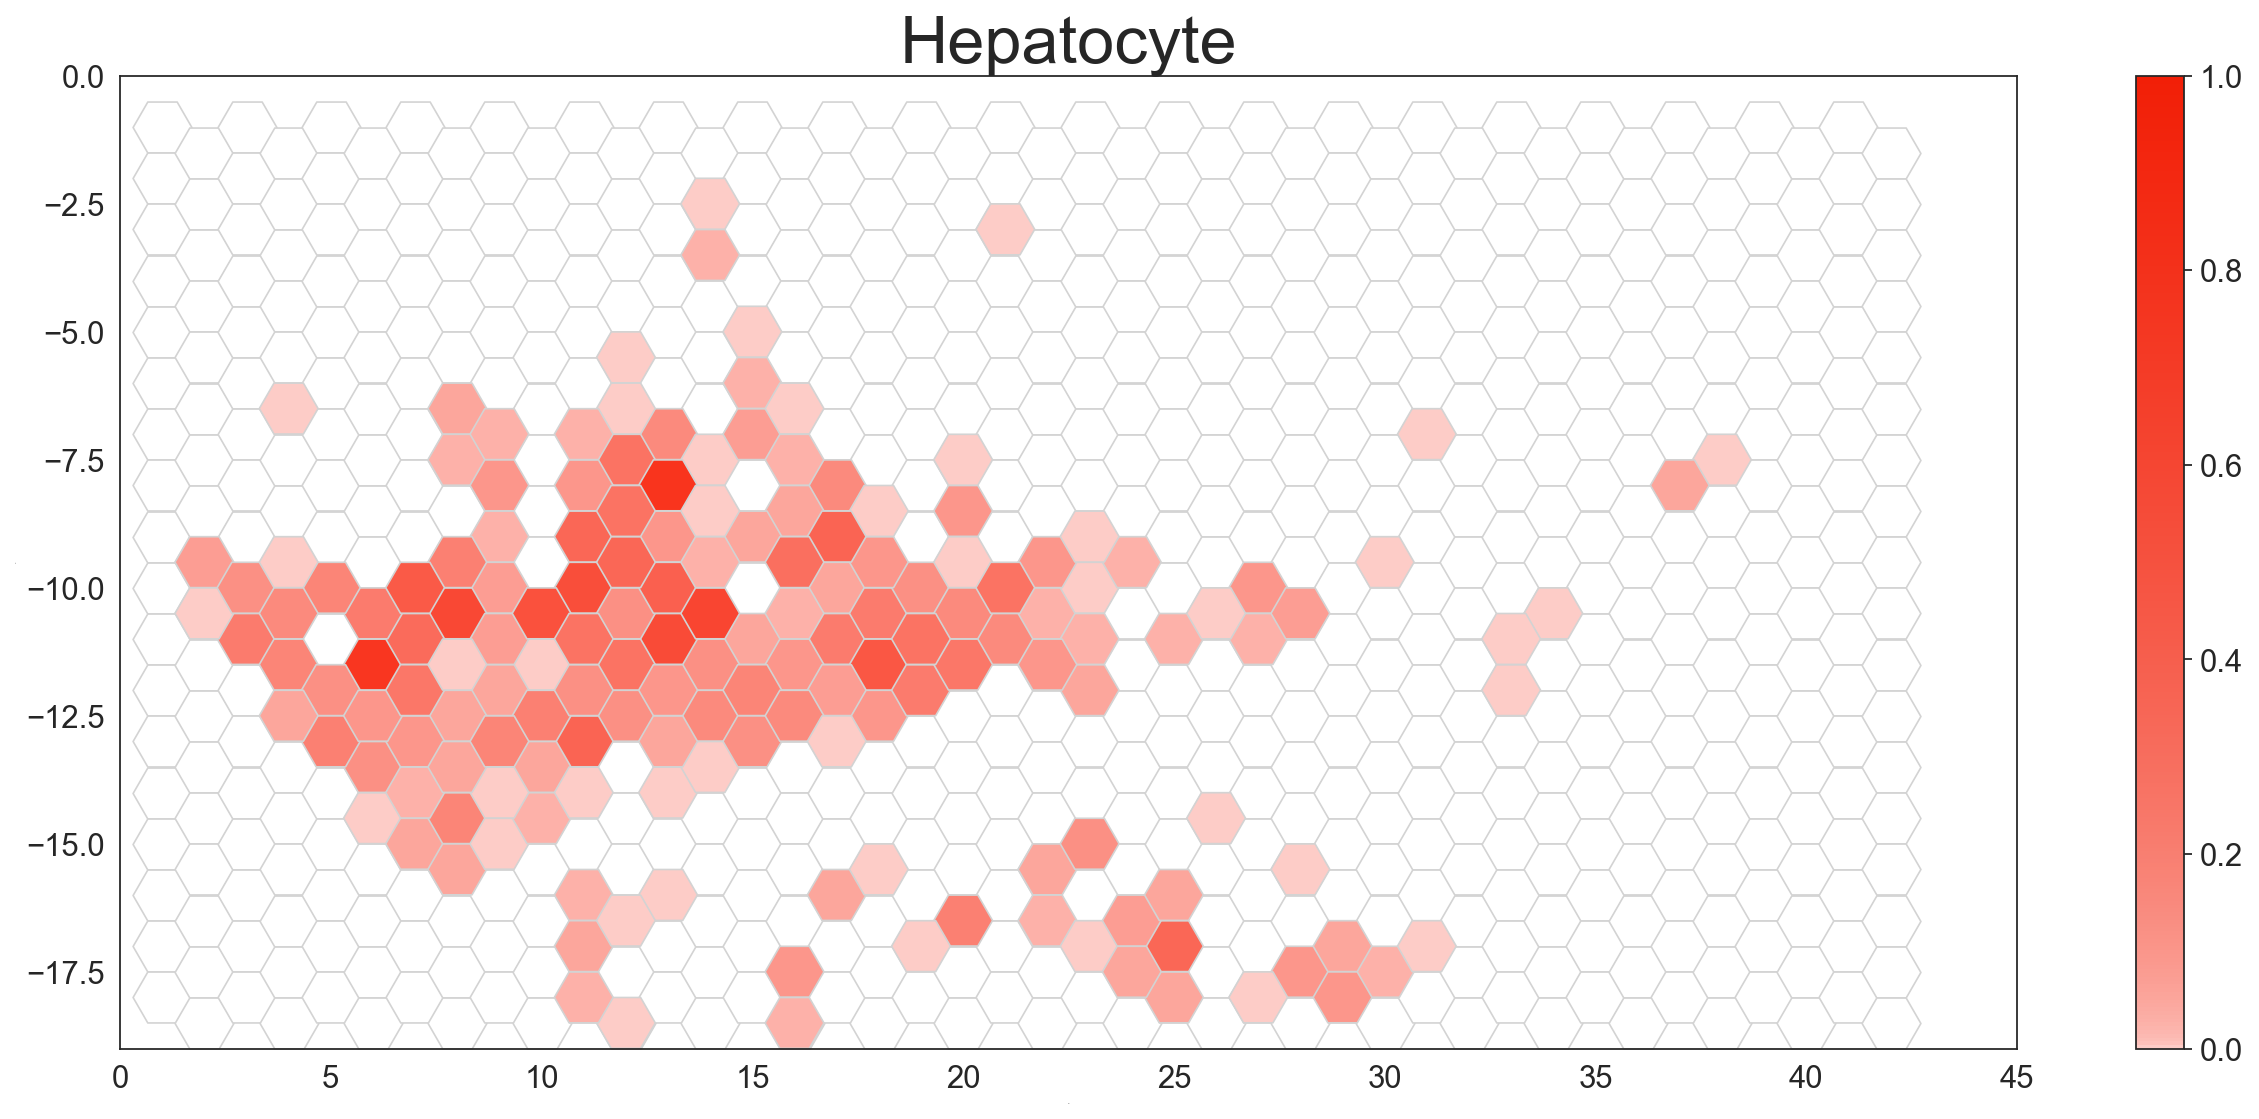

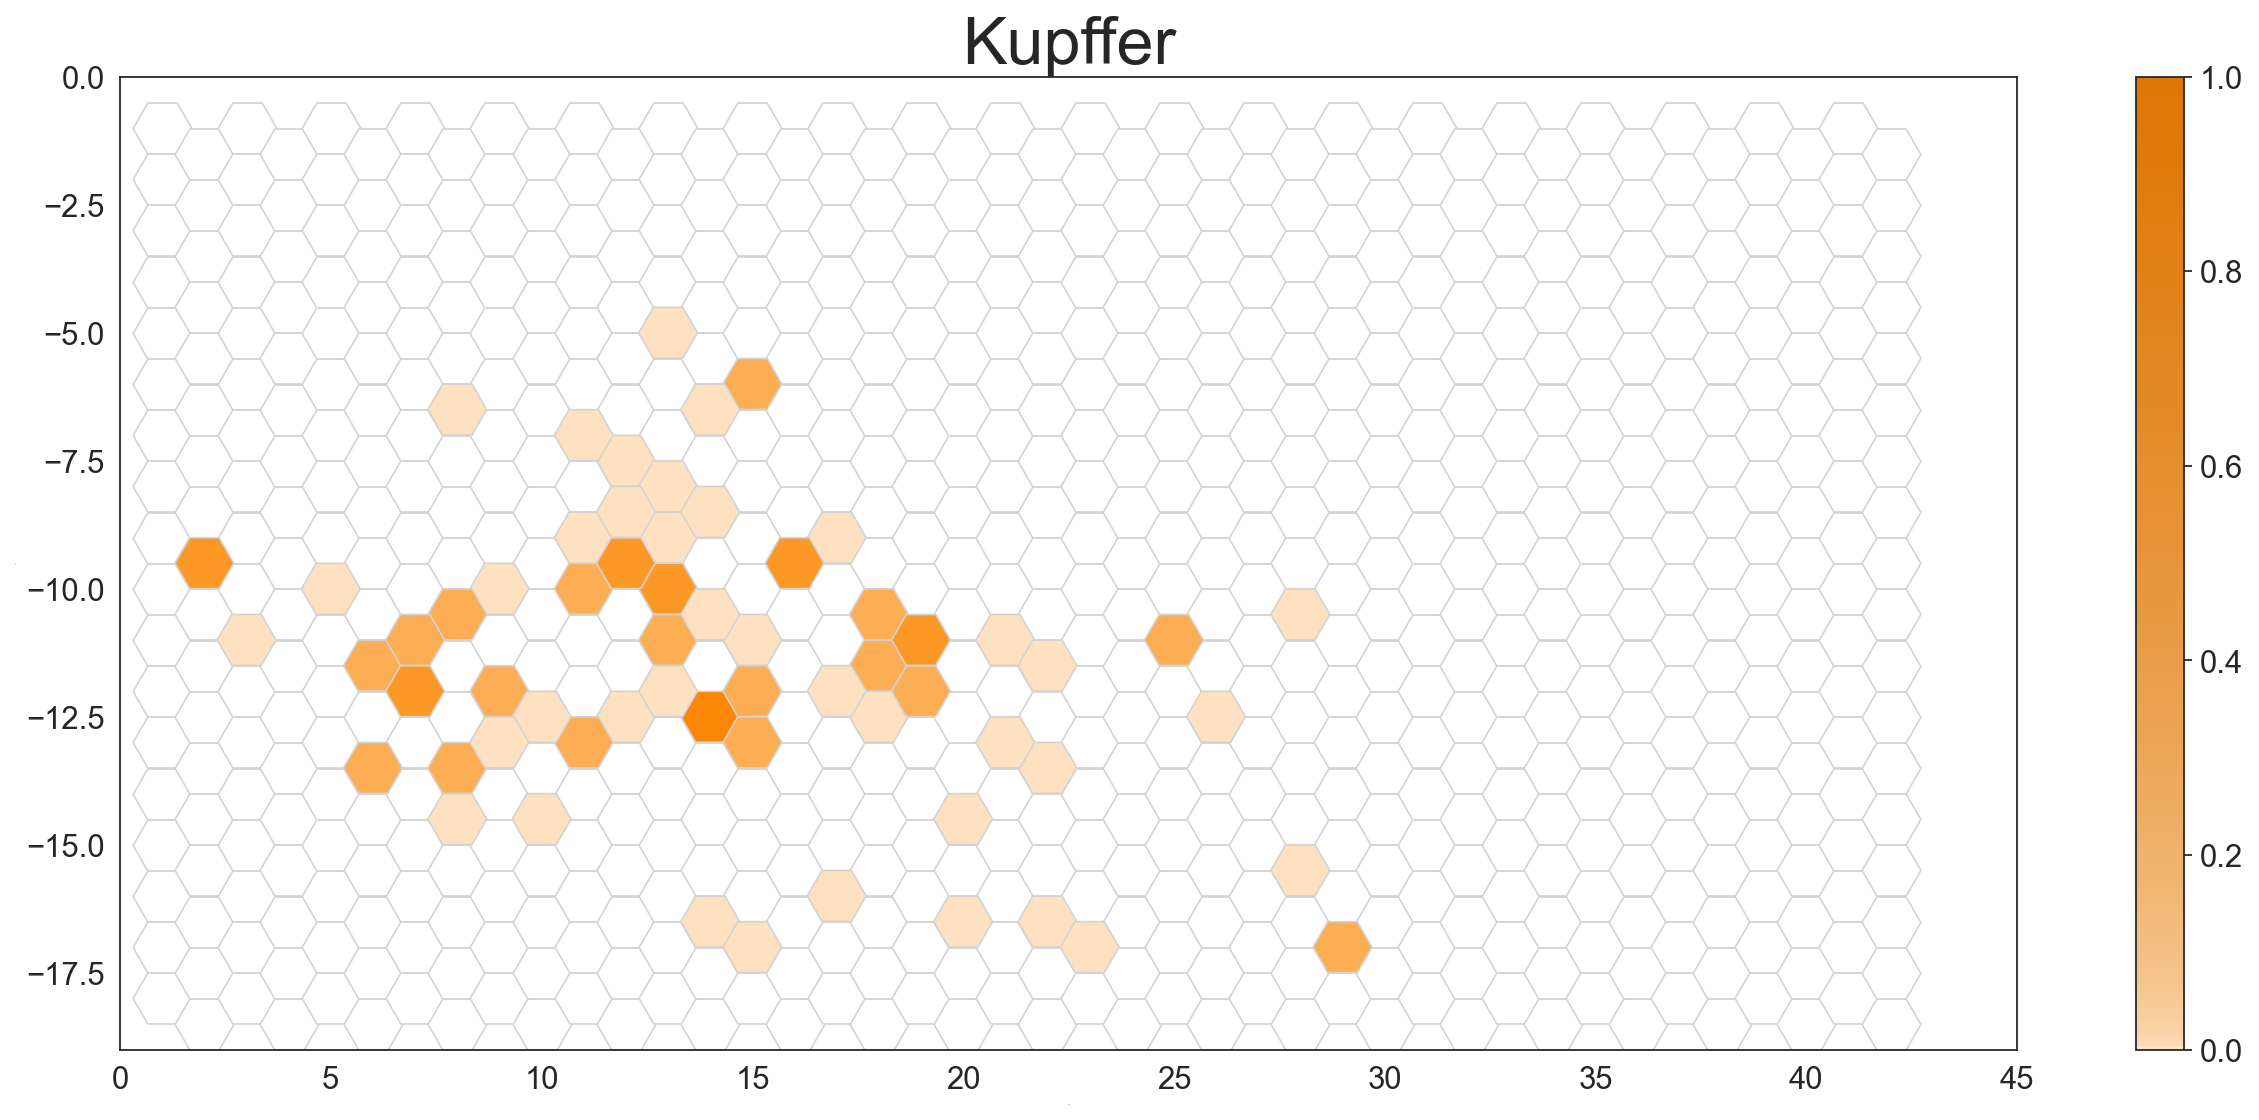

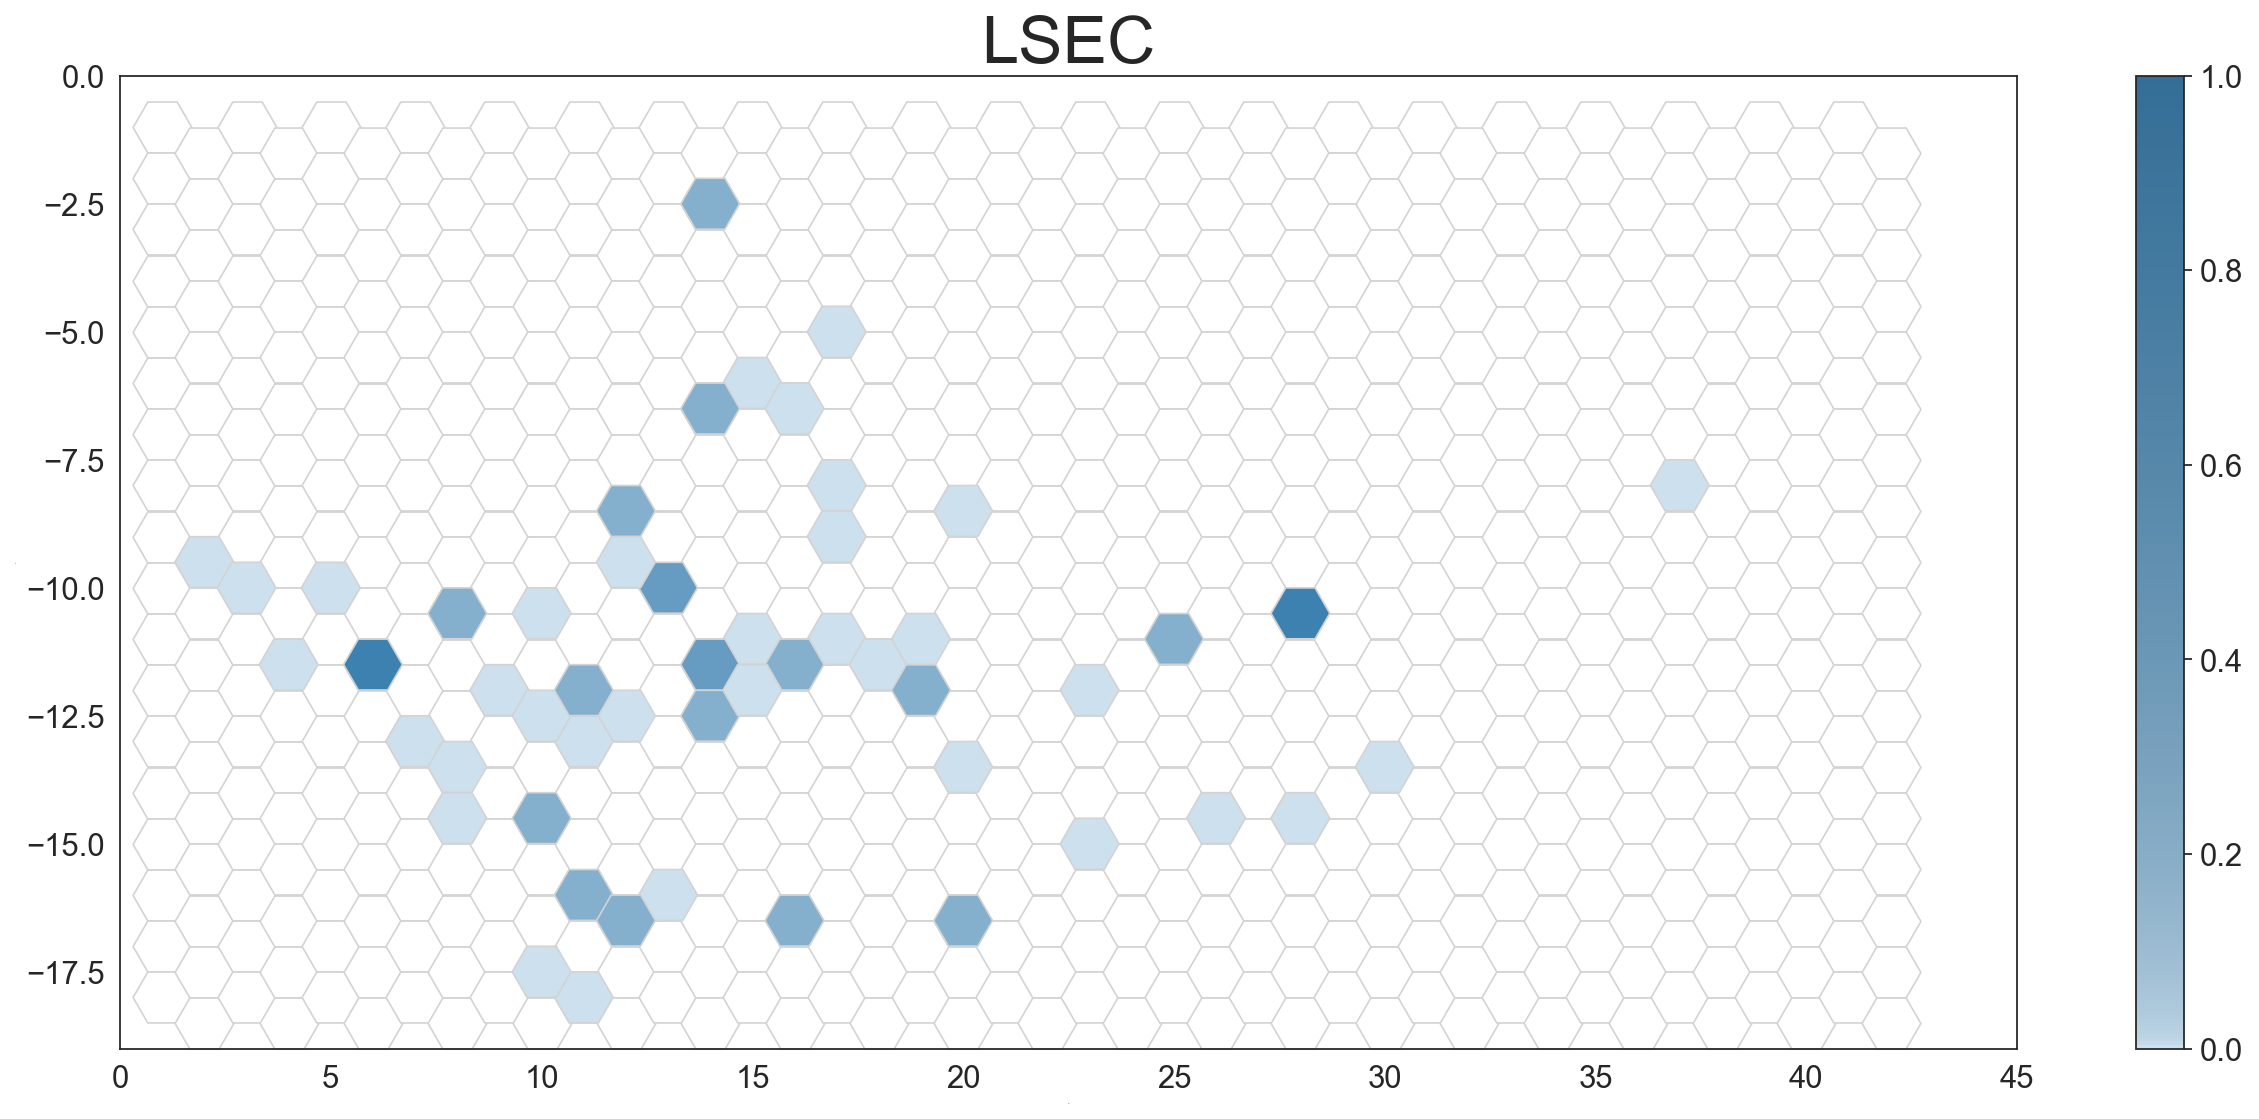

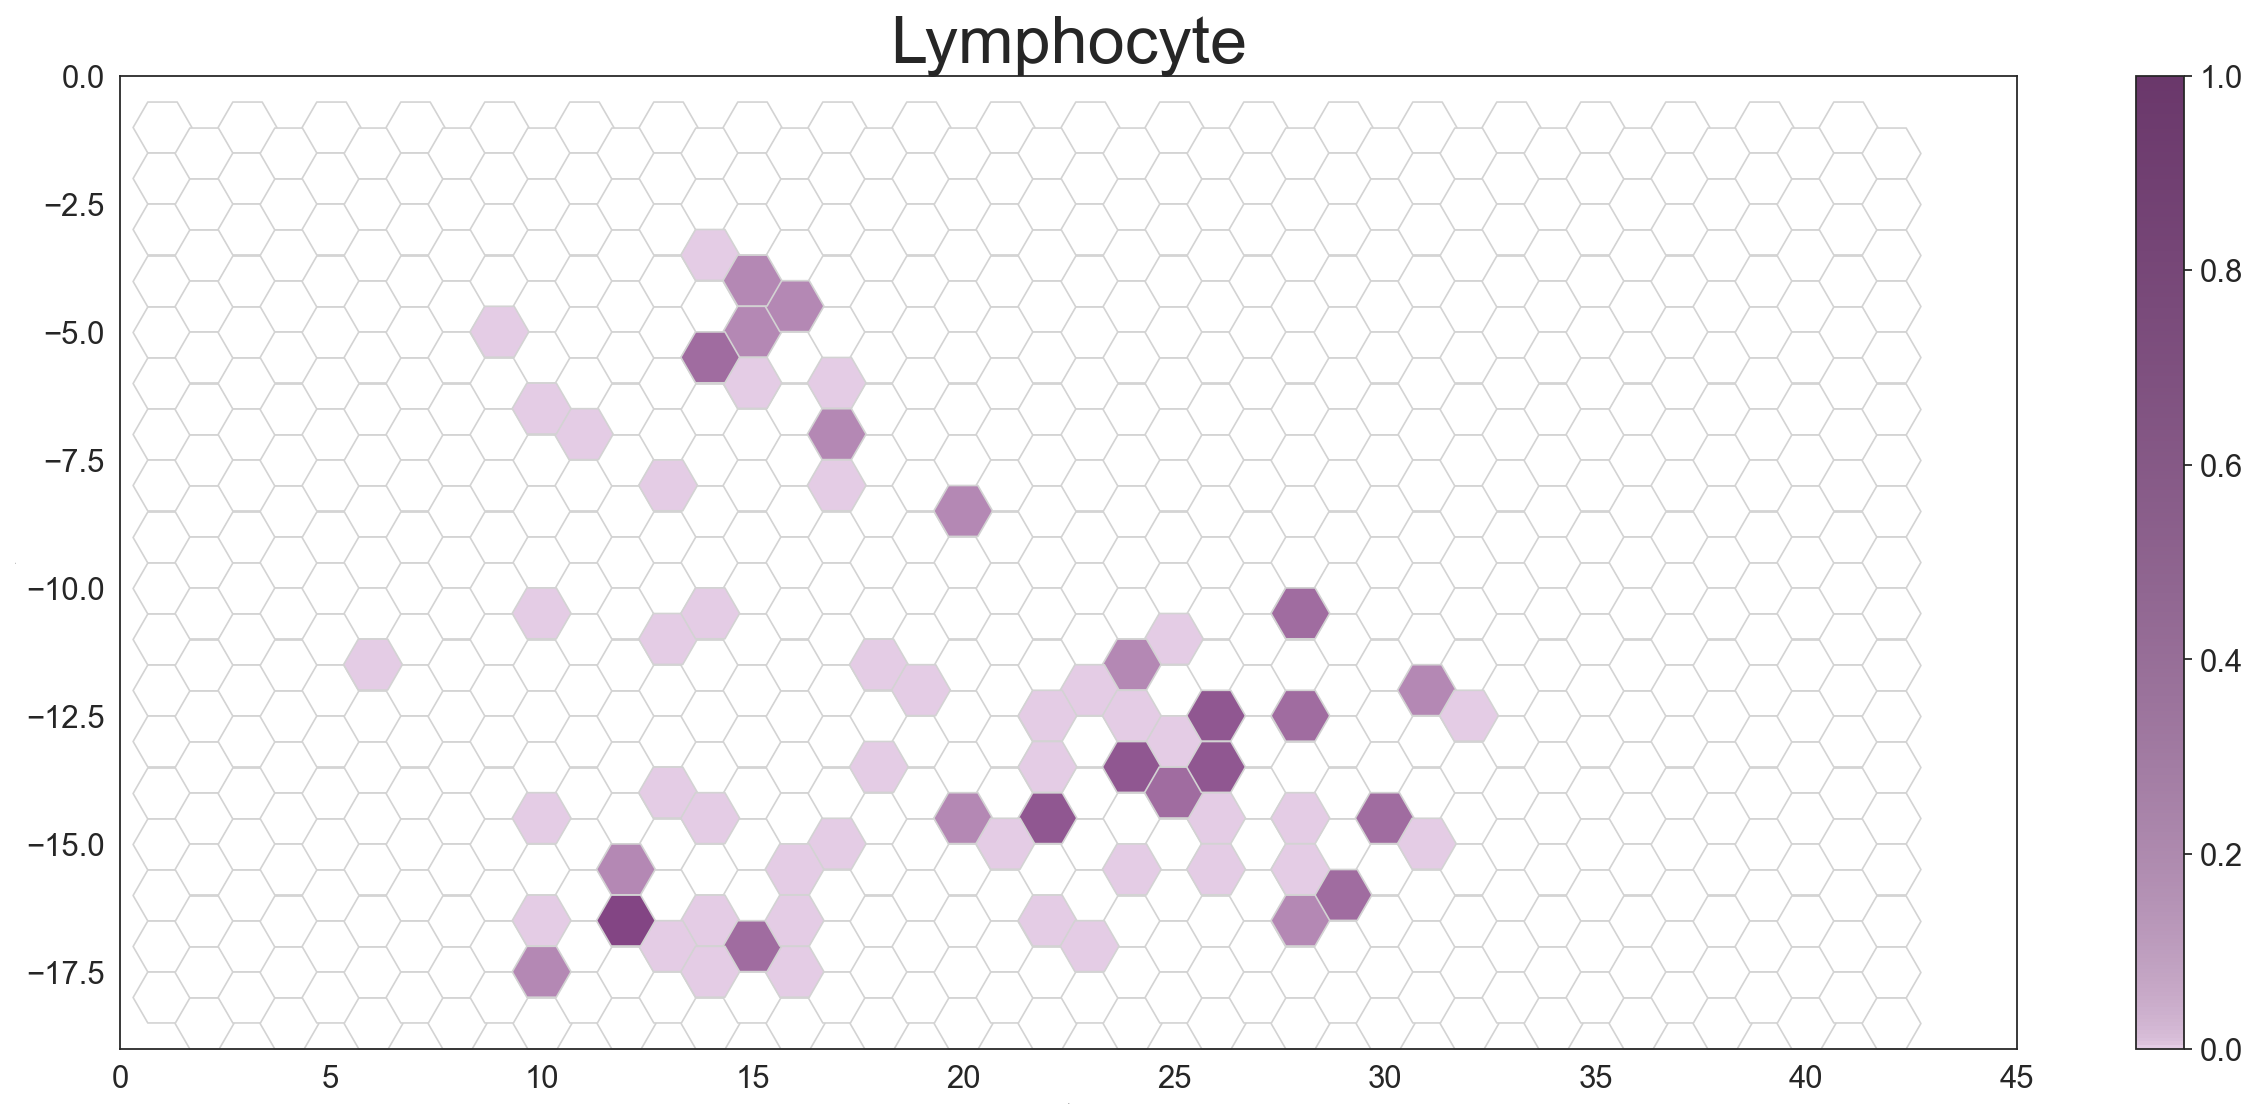

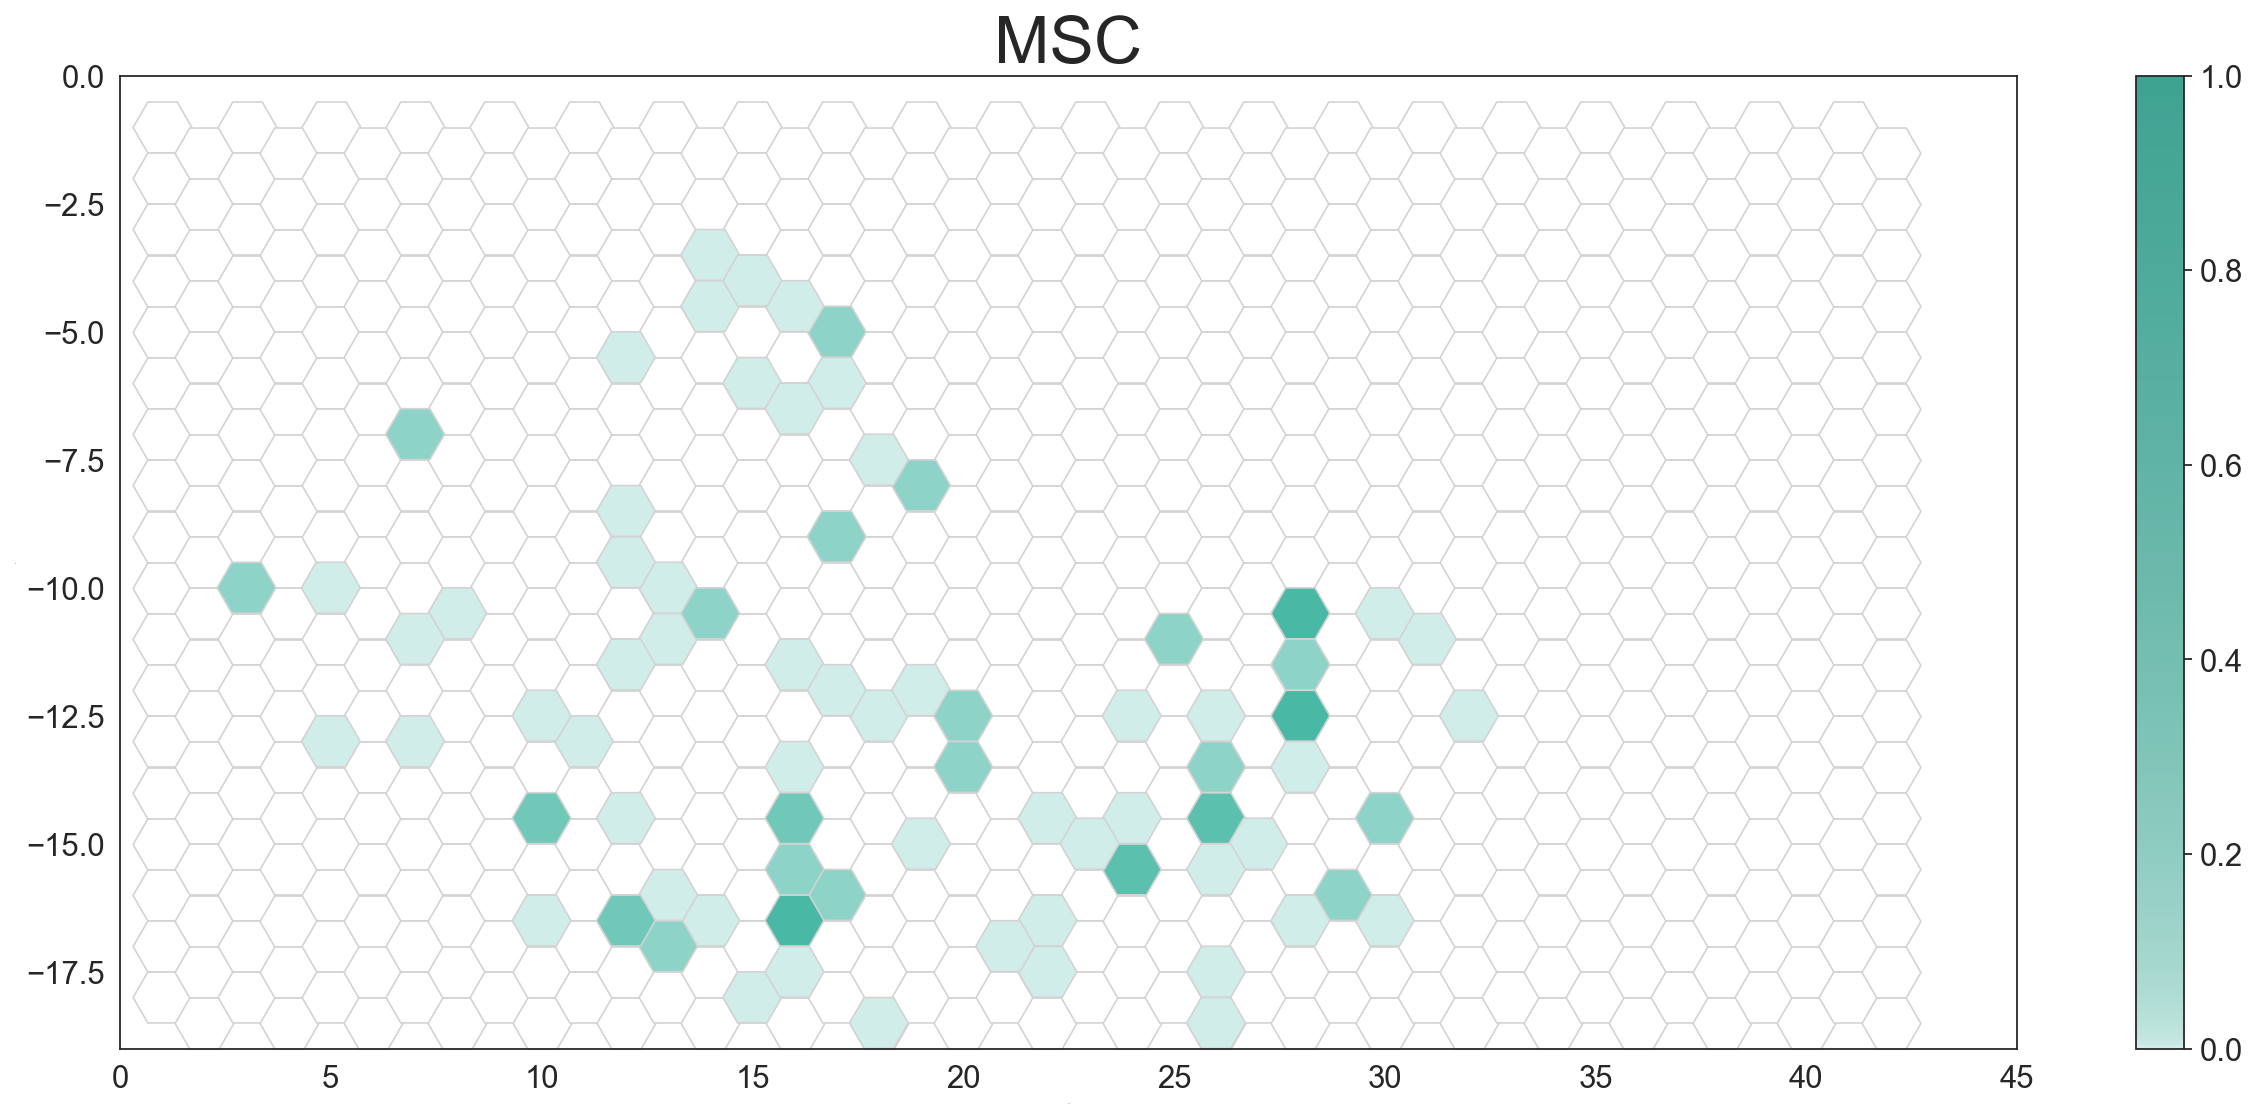

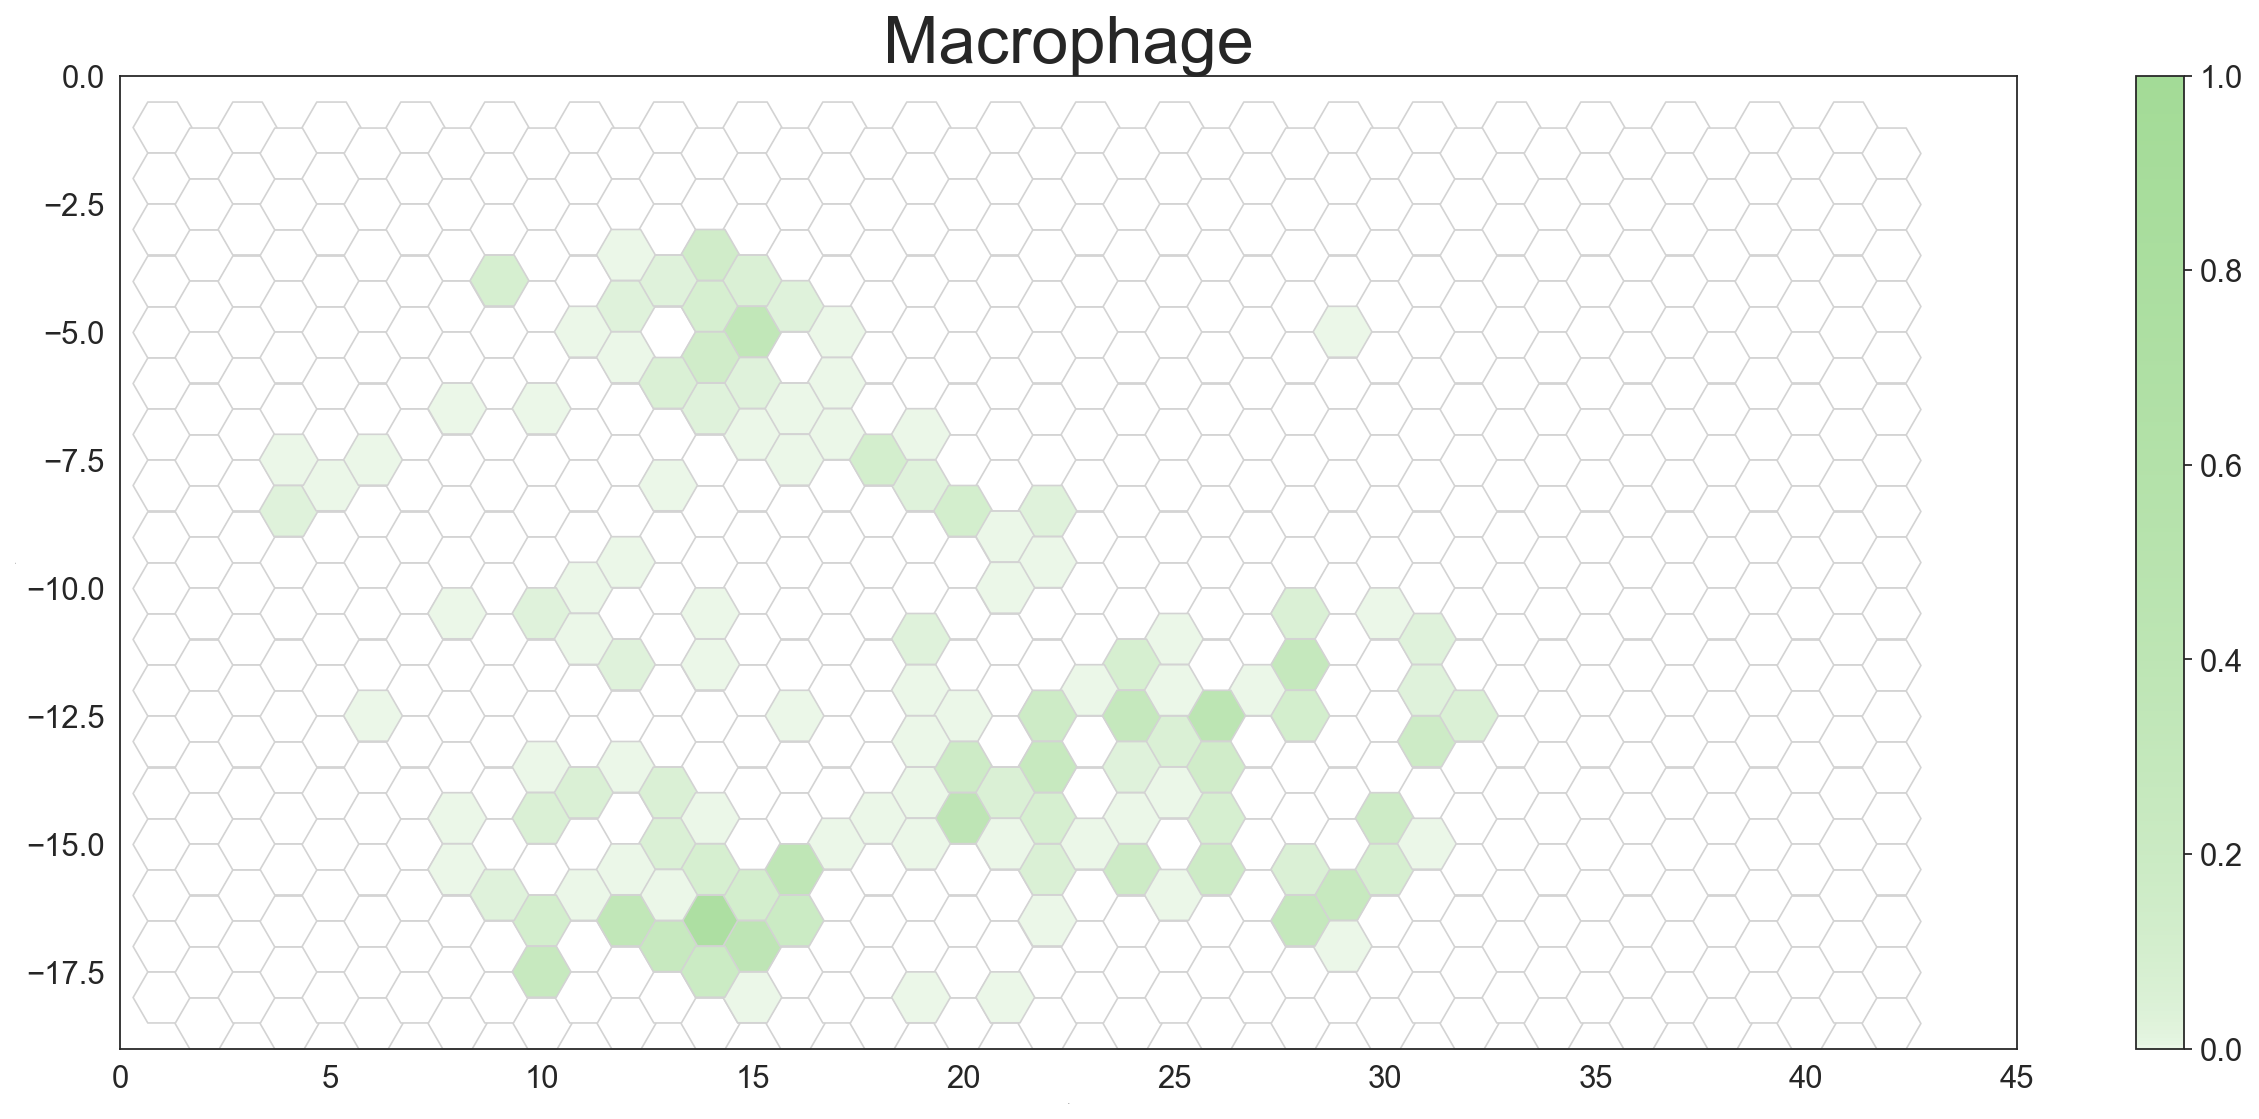

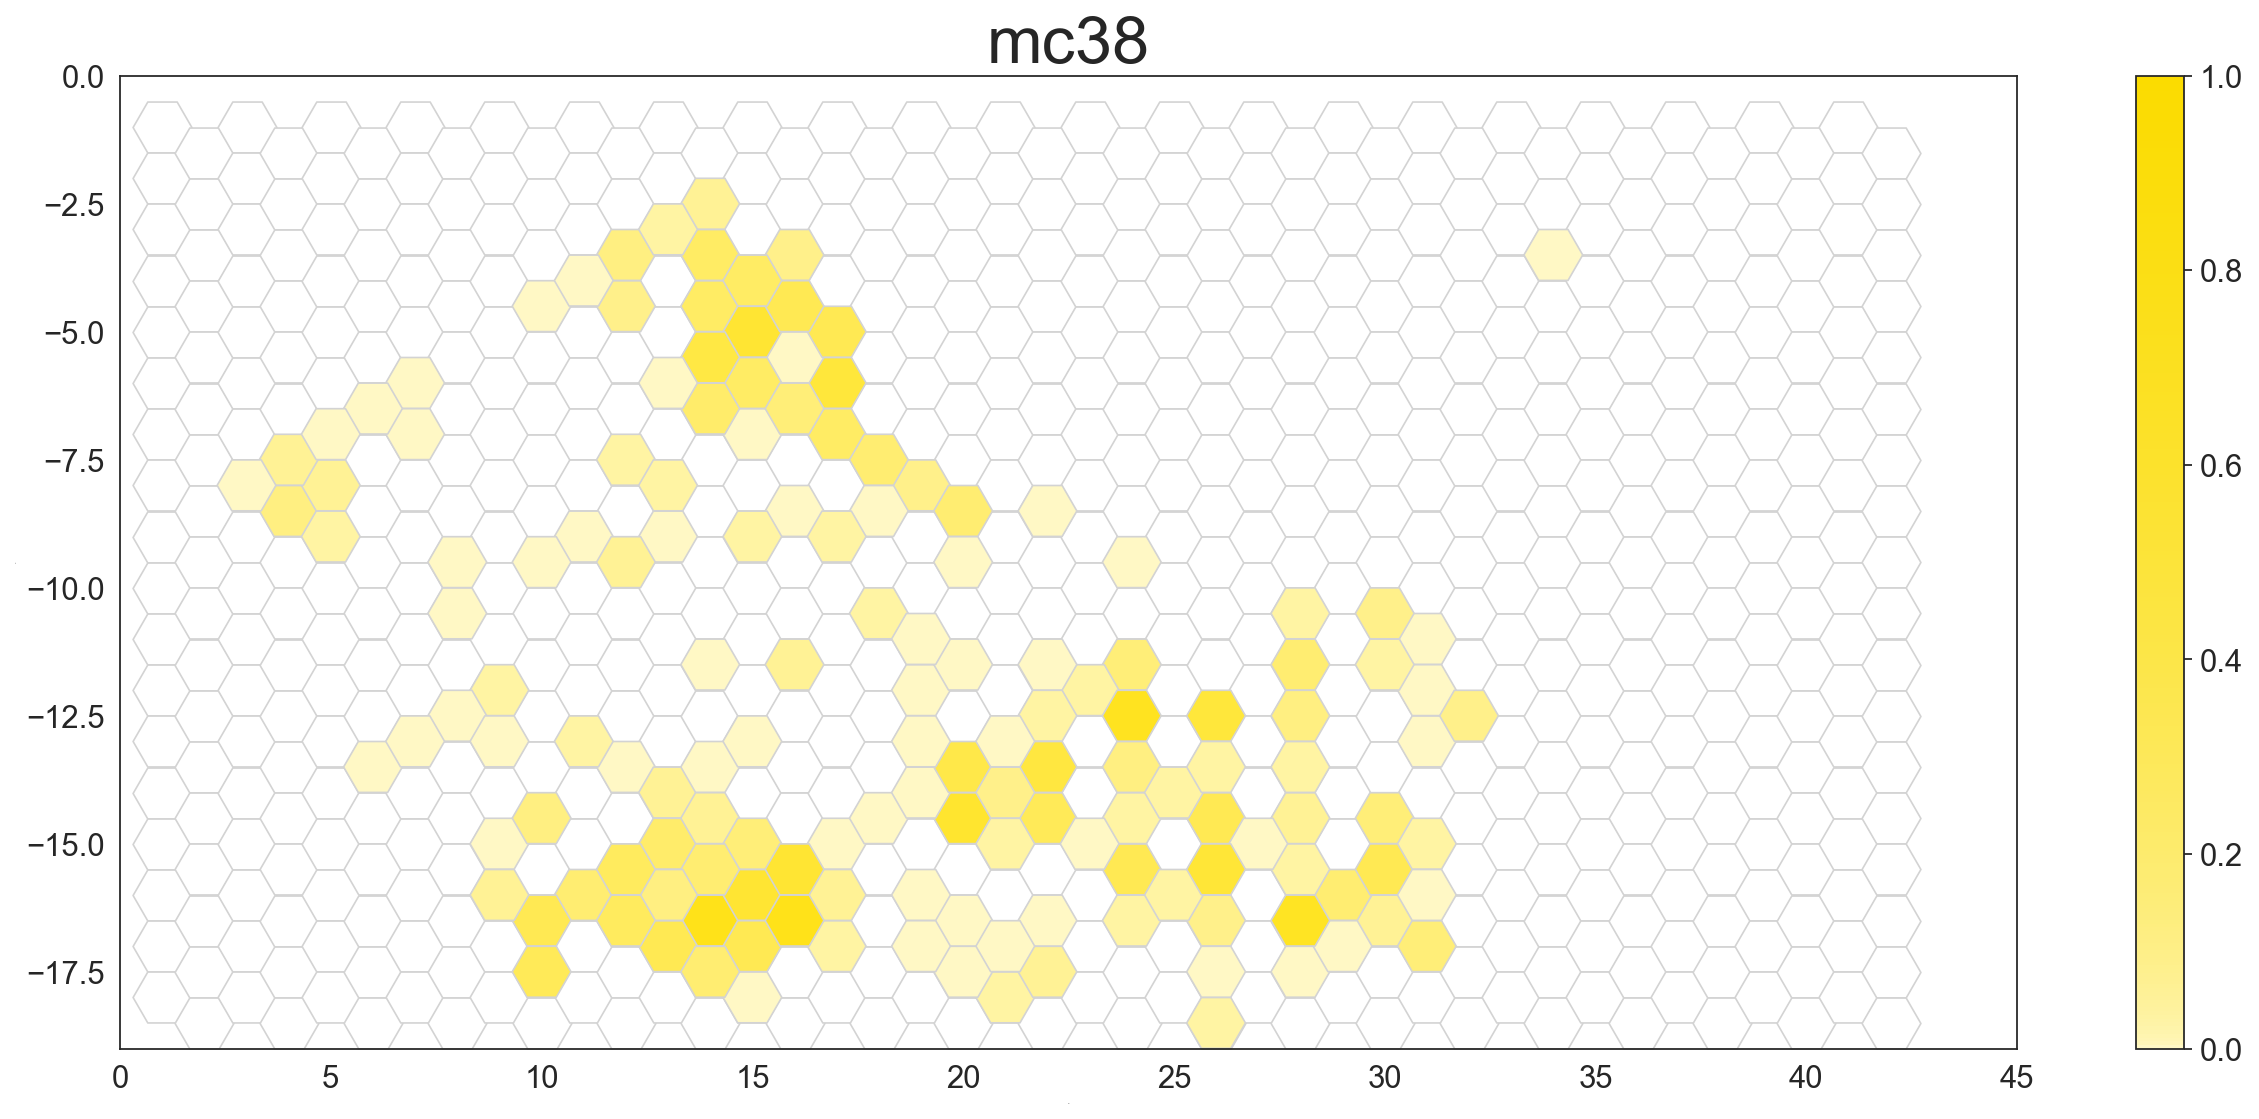

<Figure size 1520x640 with 0 Axes>

In [47]:
plt.rcParams['figure.figsize'] = [19, 8]

plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 0
plt.rcParams['axes.titlesize'] = 30




sns.set_style("white", {'axes.grid' : False})

#sns.despine(trim=True)

#fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(9, 6))


for i in adata_m.obs.CellType.cat.categories:

    plt.xlim(0, 45)
    plt.ylim(-19,0)
    
    cell_type_color = adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()
    cell_type_color_map = mpl.colors.LinearSegmentedColormap.from_list("",
                                                                       [lighten_color(cell_type_color, 0.4),
                                                                        lighten_color(cell_type_color, 1.6)],
                                                                       gamma=0.5)

    g = sns.scatterplot(data=spatial_map,
                x='X',
                y='Y',
                marker="H",
                s=700,
                legend=False,
                        ###for solid colors:
                c=['#FFFFFF'],
                edgecolor=["lightgrey"]
                

               )    
        
    g = sns.scatterplot(data=adata_batch1[adata_batch1.obs.CellType == i].obs.groupby(['barcode','X','Y']).size().reset_index(name="count"),
                x='X',
                y='Y',
                marker="H",
                s=700,
                hue=adata_batch1[adata_batch1.obs.CellType == i].obs.groupby(['barcode','X','Y']).size().reset_index(name="count")['count'].tolist(),
                palette=cell_type_color_map,
                        ###for solid colors:
#                c=[cell_type_color]#[adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()]
                edgecolor=["lightgrey"],
     
 
               )

    
    g.legend([],[], frameon=False)
    g.set_title(i)
    #plt.savefig("liver_spatial"+str(i)+".svg")
    
    points = g.get_children()[4]
    points.cmap=mpl.colors.LinearSegmentedColormap.from_list("",
                                            [lighten_color(cell_type_color, 0.4),
                                             lighten_color(cell_type_color, 1.8)],
                                                                       gamma=0.5)

    plt.colorbar(mappable=points,)
    
    
    plt.figure()

In [28]:
##Load proximity scores

scores = pd.read_csv('/Users/derekbogdanoff/projects/XYZeq/covars.with.smooth.proximity.scores_2.csv',
               header=None,
               names=['index','sample','type1','type2','barcode','num_1','num_2','prox_1','prox_2','bool'],
               index_col=0,
               usecols=['index','prox_1','prox_2']   
                    )

In [29]:
scores.index = scores.index.str.replace(r'_', '.', regex=True)
scores.index = scores.index.str.replace(r'-', '.', regex=True)

In [30]:
### scores csv is missing values L30C8 and about 1189 cells

In [31]:
adata_m = adata_m[adata_m.obs.index.isin(scores.index.to_list())]
adata_m.obs['prox_1']=scores['prox_1']
adata_m.obs['prox_2']=scores['prox_2']

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'barcode' as categorical


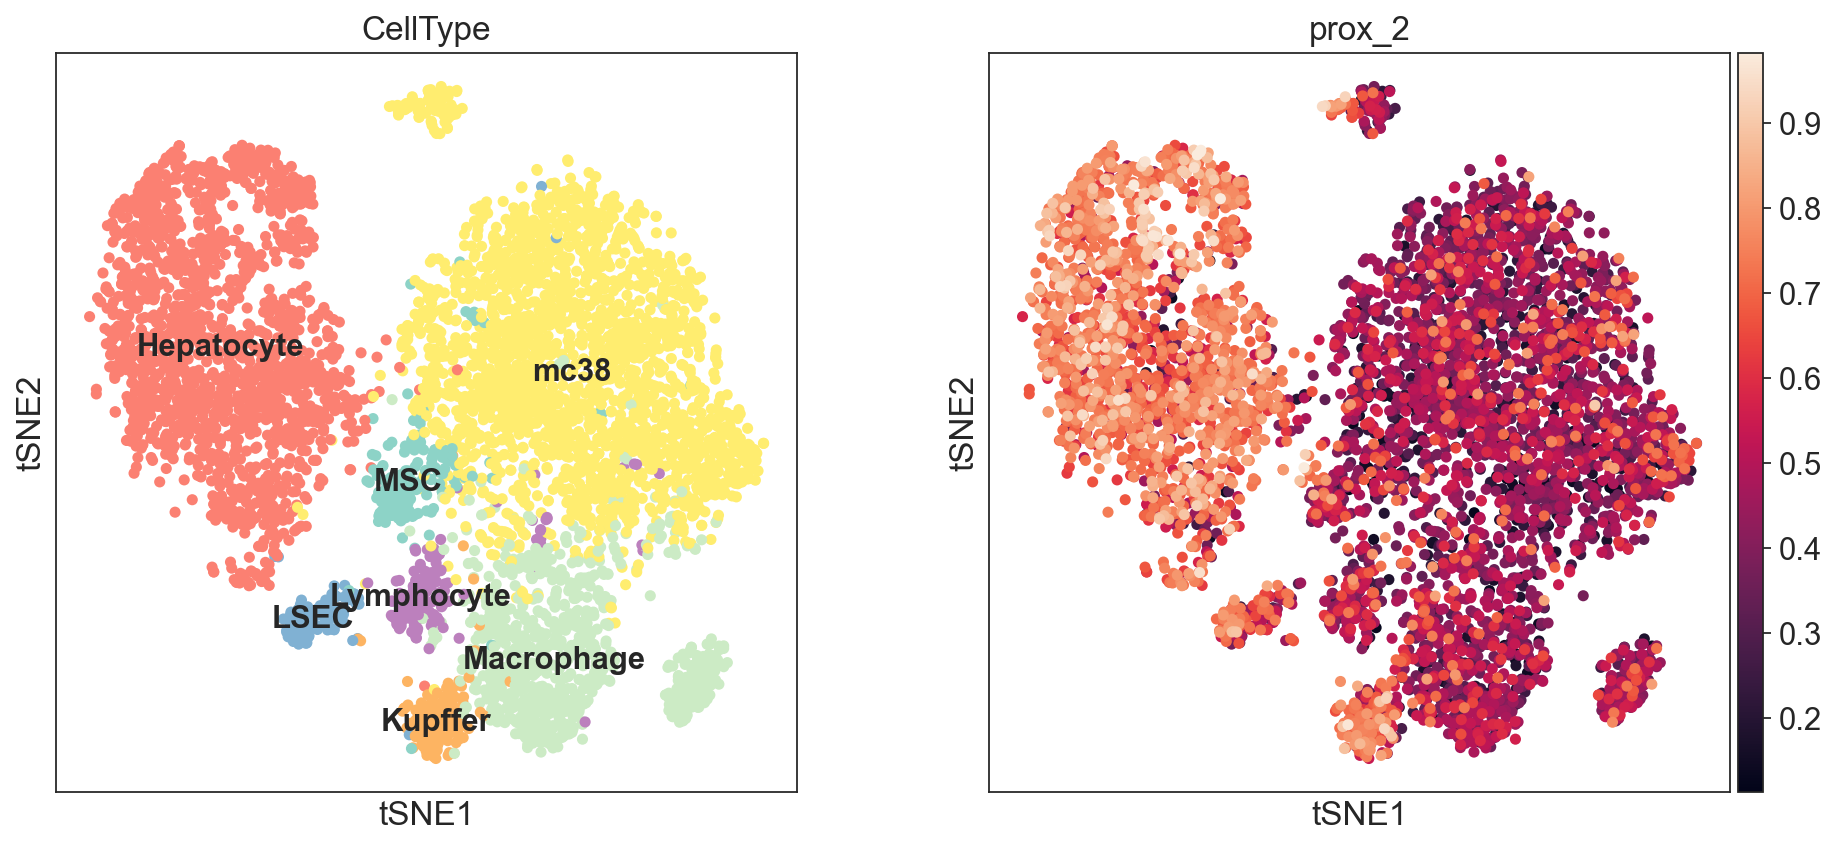

In [32]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15


sc.pl.tsne(adata_m,
          color=['CellType','prox_2'],
          size=100,
          legend_loc='on data',
          )


In [33]:
# plt.rcParams['figure.figsize'] = [15, 9]

# plt.rcParams['legend.fontsize'] = 20
# plt.rcParams['legend.markerscale'] = 3
# plt.rcParams['axes.labelsize'] = 0
# plt.rcParams['axes.titlesize'] = 30

# sns.set_style("white", {'axes.grid' : False})

# proximity_values=adata_m[adata_m.obs.batch == '1'].obs.groupby(
#     ['barcode','X','Y','prox_2']).size().reset_index(name="count")


# g = sns.scatterplot(data=proximity_values,
#                 x='X',
#                 y='Y',
#                 marker="H",
#                 s=1000,
#                 hue=proximity_values.prox_2.tolist(),
#                 palette='viridis',
# #                 legend='brief'
#                    )



# Cell Type Proportion Barplots

In [34]:
###pandas cut to bin the prox_2 obs
adata_m.obs['bins_1'] = pd.cut(adata_m.obs.prox_2, bins=20)

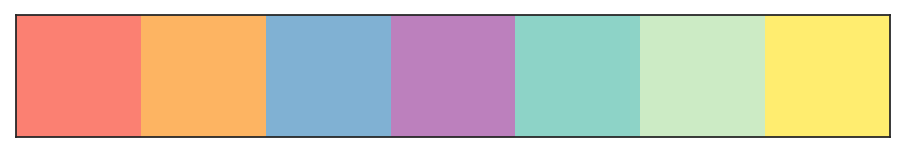

In [35]:
sns.palplot(adata_m.uns['CellType_colors'])

In [36]:
type_mat = adata_m.obs.groupby('bins_1')['CellType'].value_counts().unstack().fillna(0)

<AxesSubplot:xlabel='bins_1'>

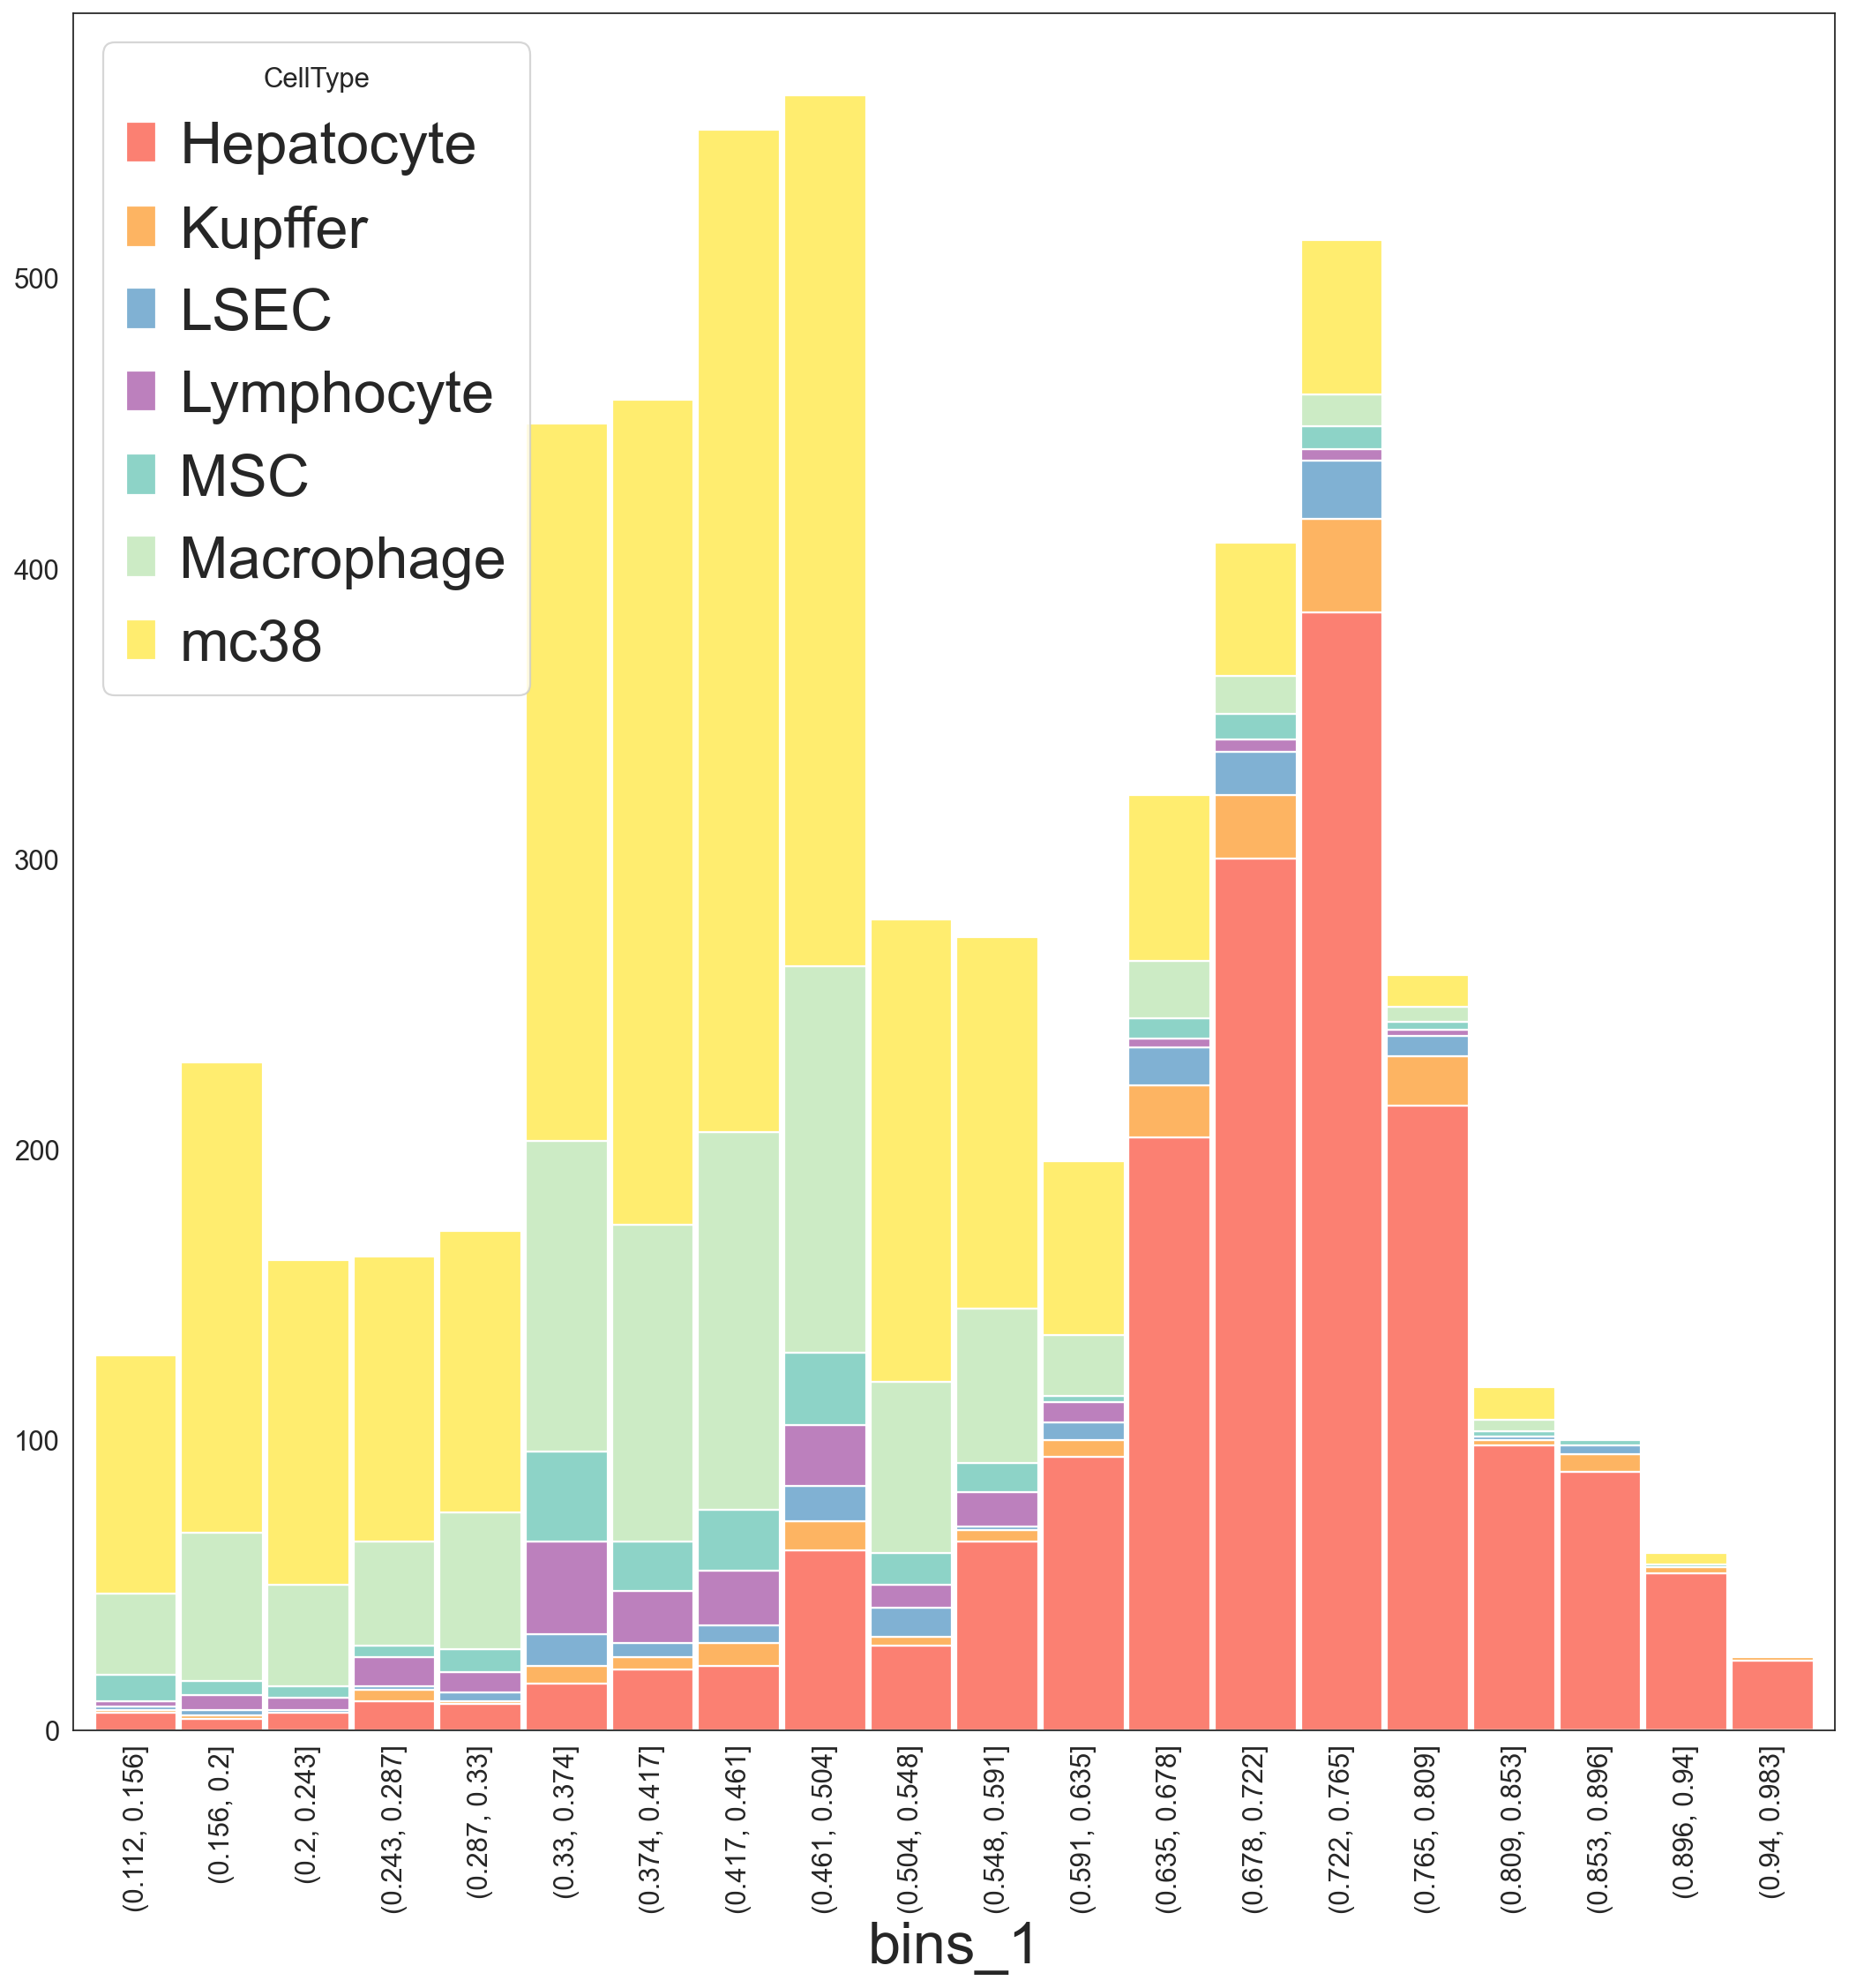

In [37]:
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30

type_mat.plot.bar(stacked='True',
                   width=0.95,
                   color=adata_m.uns['CellType_colors']
                             )

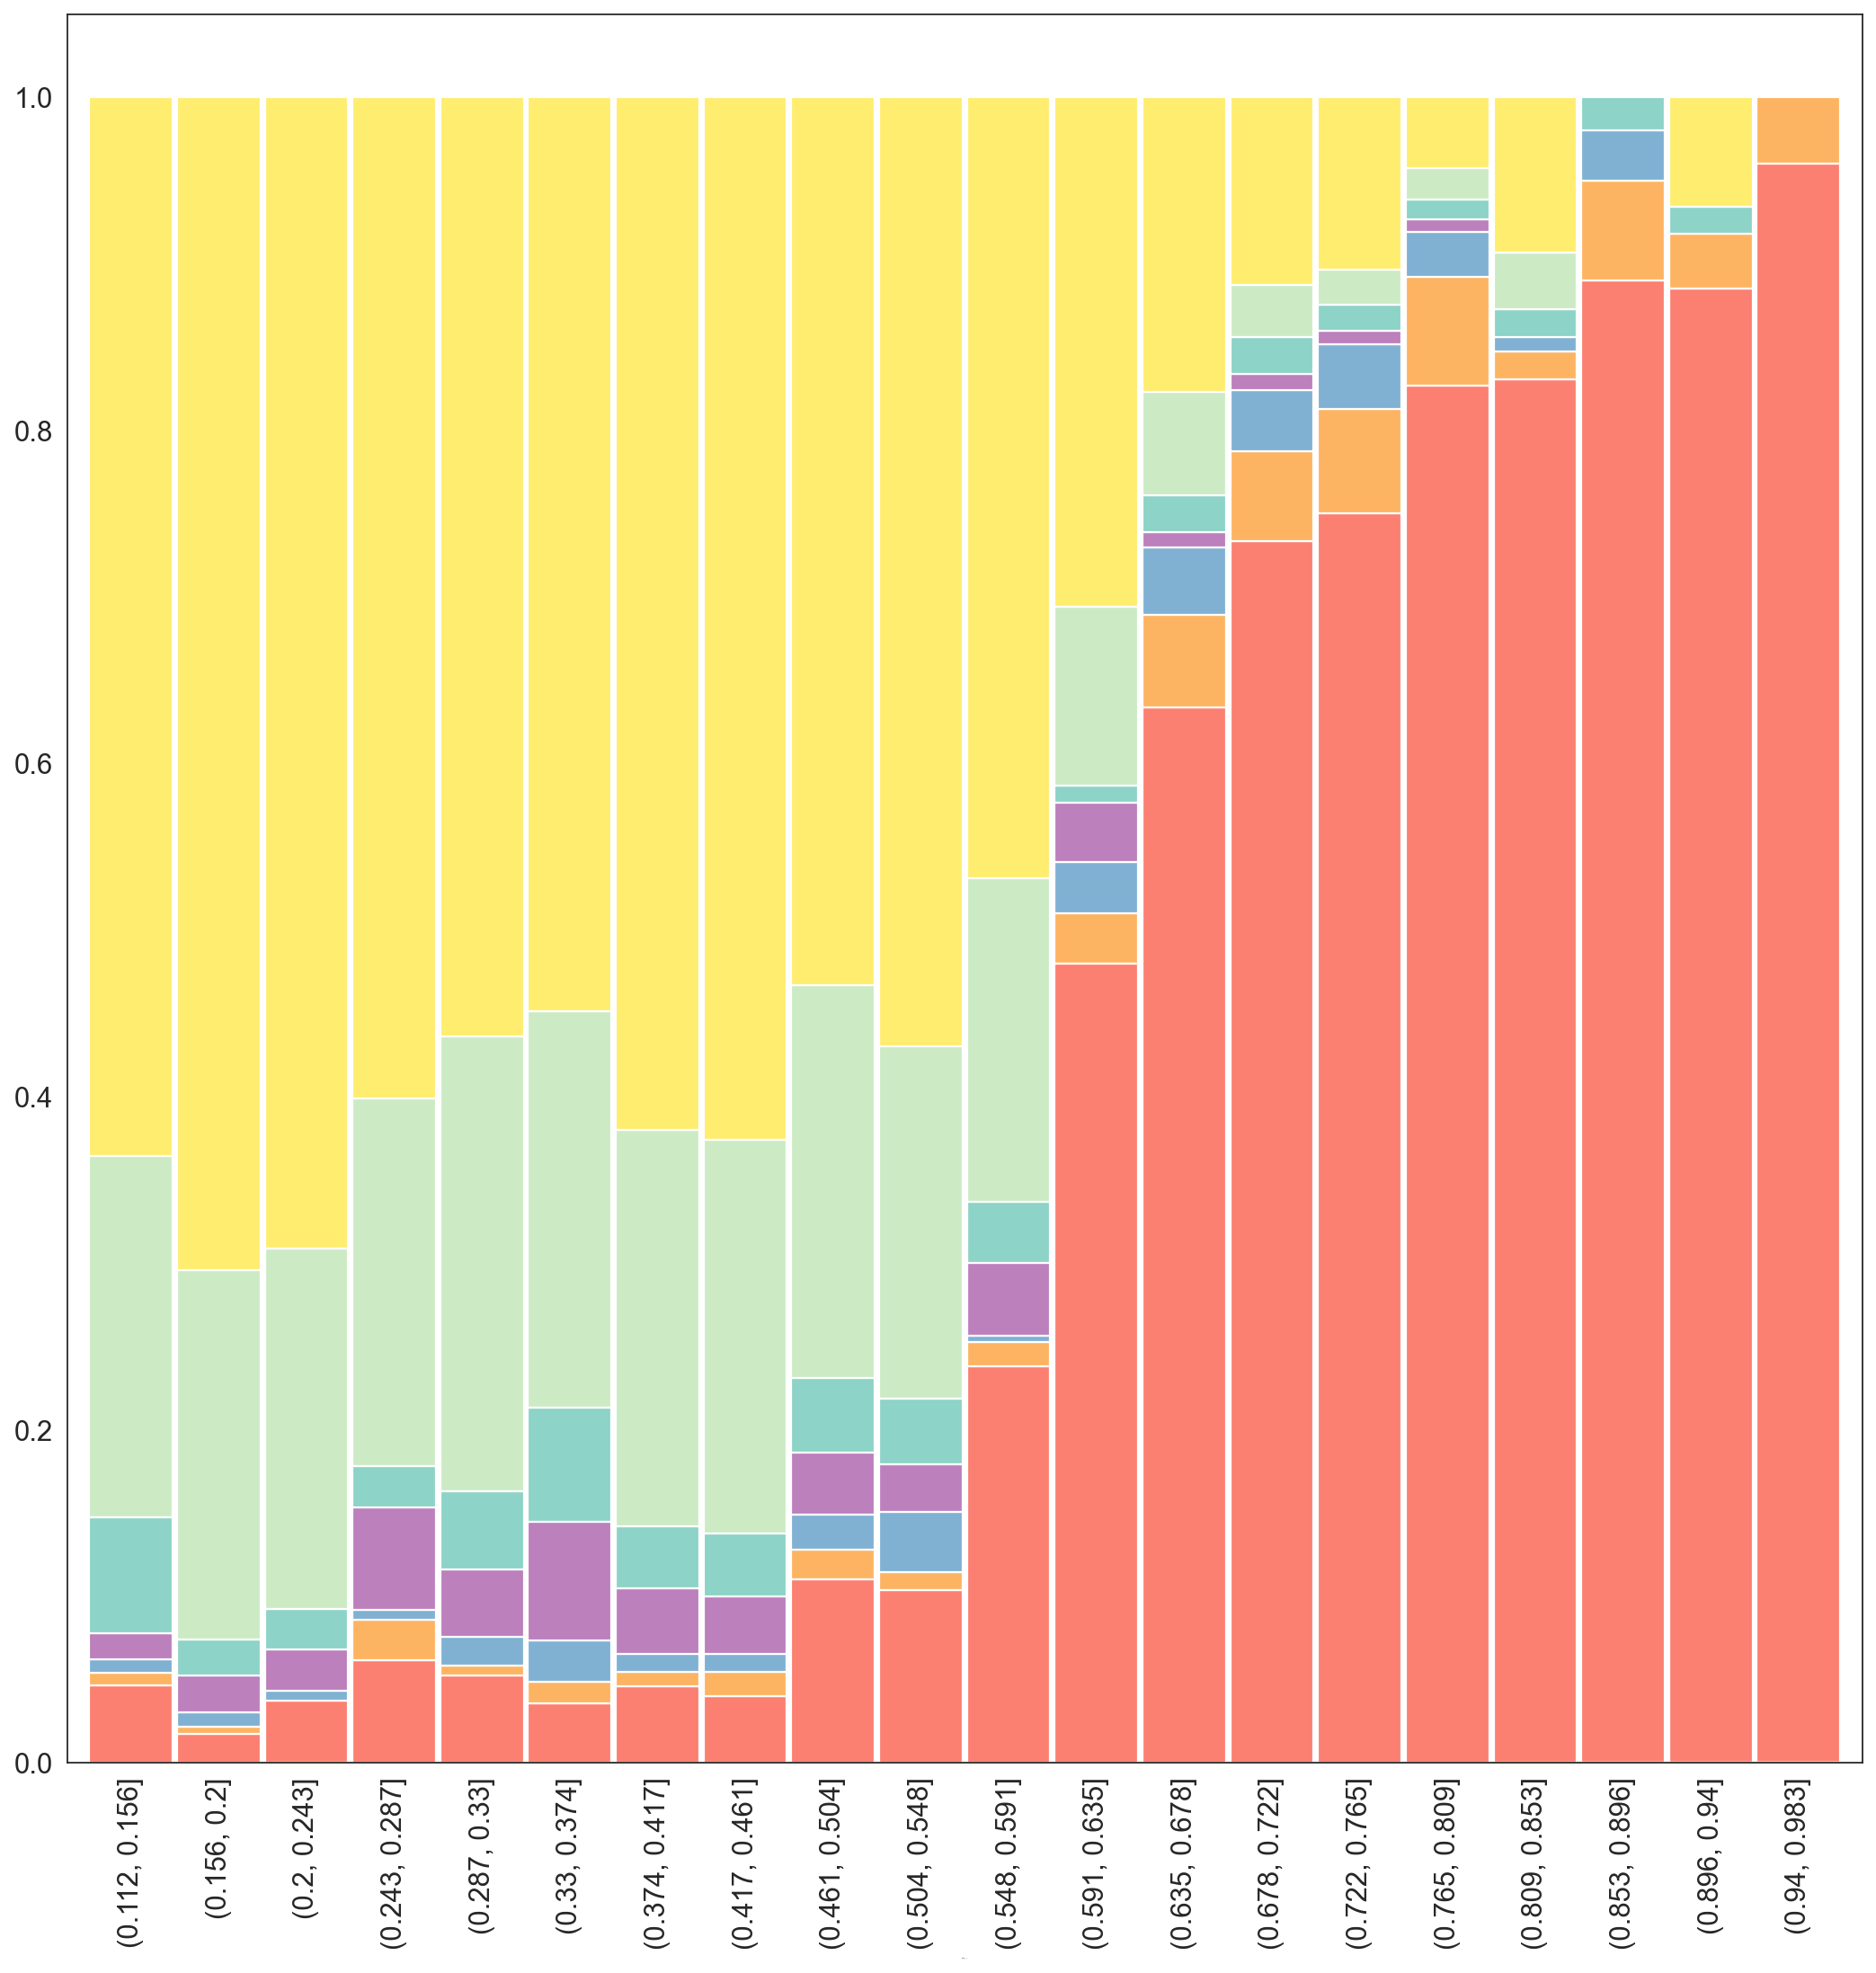

In [39]:
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 0
plt.rcParams['axes.titlesize'] = 0

type_mat.div(type_mat.sum(axis=1),axis=0).plot.bar(stacked='True',
                                                   
                                                   width=0.95,
                                                   color=adata_m.uns['CellType_colors'],
                                                   legend=False
                                                   
                             )

#plt.savefig("spatial_ratio_barplot.svg")

In [26]:
pwd

'/Users/derekbogdanoff/projects/XYZeq/Repo/spatial/notebooks/figures'

In [23]:
adata_m.obs

,batch,n_counts,log_counts,n_genes,barcode,percent_mito_mouse,percent_mito_human,mouse_counts,human_counts,ratio,...,contam_init,tsne_density,leiden,CellType,__is_in_cluster__,X,Y,prox_1,prox_2,bins_1
index,,,,,,,,,,,,,,,,,,,,,
L10C.P1A01F.CACTGGCGGTATTAGA.0,0,808.202087,6.694813,462,CACTGGCGGTATTAGA,0.000000,0.000000e+00,763.485046,44.717220,1.232326,...,0.046935,0.661256,3,Hepatocyte,False,6,-13.5,0.961538,0.801644,"(0.765, 0.809]"
L10C.P1A01F.CCTTGTACAGGCATGA.0,0,1045.261353,6.952023,530,CCTTGTACAGGCATGA,0.000000,5.299168e-17,1025.530640,19.731436,1.715790,...,0.000788,0.417486,4,mc38,True,17,-7.0,0.000000,0.727415,"(0.722, 0.765]"
L10C.P1A01F.CACGACCTCACGACTA.0,0,717.651733,6.575984,397,CACGACCTCACGACTA,0.000000,0.000000e+00,707.671387,9.980301,1.850688,...,0.081837,0.373657,9,Kupffer,False,8,-10.5,0.972222,0.888194,"(0.853, 0.896]"
L10C.P1A02F.ATTGACCAGAAGATGC.0,0,760.683838,6.634218,458,ATTGACCAGAAGATGC,0.000000,0.000000e+00,728.789001,31.895189,1.358877,...,0.003526,0.547426,3,Hepatocyte,False,9,-2.0,1.000000,0.915088,"(0.896, 0.94]"
L10C.P1A03F.GAGGTGATCTTCTCAA.0,0,1022.485962,6.929993,610,GAGGTGATCTTCTCAA,0.097490,0.000000e+00,996.758911,25.727455,1.588193,...,0.022793,0.396252,4,mc38,True,15,-6.0,0.758621,0.820251,"(0.809, 0.853]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L30C.P2H09F.CTGCTTCGGCCATCAG.3,3,527.605469,6.268349,335,CTGCTTCGGCCATCAG,0.000000,0.000000e+00,494.465576,33.139854,1.173785,...,0.267553,0.463247,2,Macrophage,False,15,-5.0,0.000000,0.428115,"(0.417, 0.461]"
L30C.P2H11F.GCCAGTACTGCGTGTT.3,3,577.553955,6.358802,445,GCCAGTACTGCGTGTT,0.345282,0.000000e+00,557.849670,19.704298,1.451956,...,0.012157,0.499809,0,mc38,True,15,-13.0,0.272727,0.437233,"(0.417, 0.461]"
L30C.P2H12F.TATAAGCCGACGACGC.3,3,871.832520,6.770598,531,TATAAGCCGACGACGC,0.000000,0.000000e+00,853.875061,17.957762,1.677142,...,0.007832,0.450359,0,mc38,True,12,-15.5,0.000000,0.519925,"(0.504, 0.548]"


In [24]:
import diffxpy.api as de
import batchglm.api as glm

ModuleNotFoundError: No module named 'diffxpy'

In [25]:
print(de.__version__)
print(glm.__version__)

v0.7.4
v0.7.4


In [26]:
adata_diff = adata_m.raw.to_adata()

In [27]:
adata_diff = adata_diff[:,adata_diff.var_names.str.startswith('mm10_')]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [36]:
det=de.test.continuous_1d(
    
    data=adata_diff.X,
    sample_description=adata_diff.obs,
    gene_names=adata_diff.var_names,
    formula_loc="~ 1 + prox_2",
    formula_scale="~1",
    factor_loc_totest="prox_2",
    continuous="prox_2",
    size_factors=np.random.uniform(0.2, 2, adata_diff.n_obs),
    df=4,
    quick_scale=False

)

/Users/derekbogdanoff/miniconda3/envs/xyzeq_2/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/Users/derekbogdanoff/miniconda3/envs/xyzeq_2/lib/python3.6/site-packages/batchglm/models/base_glm/utils.py:159: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  for g in np.unique(grouping)
/Users/derekbogdanoff/miniconda3/envs/xyzeq_2/lib/python3.6/site-packages/batchglm/models/base_glm/utils.py:172: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.s

training location model: True
training scale model: True
iter   0: ll=14732092.962938
iter   1: ll=14044079.642724, converged: 0.00% (loc: 18.87%, scale update: False), in 20.91sec
iter   2: ll=13836640.869559, converged: 0.00% (loc: 19.76%, scale update: False), in 18.63sec
iter   3: ll=13795267.027119, converged: 0.00% (loc: 19.80%, scale update: False), in 16.93sec
iter   4: ll=13788509.034626, converged: 0.00% (loc: 19.83%, scale update: False), in 16.58sec
iter   5: ll=13786881.788974, converged: 0.00% (loc: 19.86%, scale update: False), in 17.73sec
Fitting 24917 dispersion models: (progress not available with multiprocessing)

Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):


In [42]:
import tensorflow

In [43]:
tensorflow.__version__

'2.3.0'

In [44]:
import numpy 

In [46]:
numpy.__version__

'1.18.5'

In [ ]:
det = de.test.continuous_1d(
    data=data.X,
    sample_description=data.obs,
    gene_names=data.var_names,
    formula_loc="~ 1 + time",
    formula_scale="~ 1",
    factor_loc_totest="time",
    continuous="time",
    size_factors=np.random.uniform(0.2, 2, data.n_obs),
    df=4,
    quick_scale=False
)